<a href="https://colab.research.google.com/github/sukki-lee/Melt-pool-Image-Enhancer/blob/main/Melt_pool_image_enhancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import zipfile as zp
import os
import json
import cv2
from PIL import Image

## Unzip Melt-pool monitoring images

In [2]:
zp.ZipFile('MPM_Part04_L0001.zip').extractall("./MPM_Part04_L0001")
fLoc = './MPM_Part04_L0001'
# os.listdir(fLoc)

* 'imageList' needs to be sorted, each file name will be used as index of future data

In [3]:
imageList = os.listdir(fLoc)
imageList.sort()
imageList

['Frame000002.bmp',
 'Frame000003.bmp',
 'Frame000004.bmp',
 'Frame000005.bmp',
 'Frame000006.bmp',
 'Frame000007.bmp',
 'Frame000008.bmp',
 'Frame000009.bmp',
 'Frame000010.bmp',
 'Frame000011.bmp',
 'Frame000012.bmp',
 'Frame000013.bmp',
 'Frame000014.bmp',
 'Frame000015.bmp',
 'Frame000016.bmp',
 'Frame000017.bmp',
 'Frame000018.bmp',
 'Frame000019.bmp',
 'Frame000020.bmp',
 'Frame000021.bmp',
 'Frame000022.bmp',
 'Frame000023.bmp',
 'Frame000024.bmp',
 'Frame000025.bmp',
 'Frame000026.bmp',
 'Frame000027.bmp',
 'Frame000028.bmp',
 'Frame000029.bmp',
 'Frame000030.bmp',
 'Frame000031.bmp',
 'Frame000032.bmp',
 'Frame000033.bmp',
 'Frame000034.bmp',
 'Frame000035.bmp',
 'Frame000036.bmp',
 'Frame000037.bmp',
 'Frame000038.bmp',
 'Frame000039.bmp',
 'Frame000040.bmp',
 'Frame000041.bmp',
 'Frame000042.bmp',
 'Frame000043.bmp',
 'Frame000044.bmp',
 'Frame000045.bmp',
 'Frame000046.bmp',
 'Frame000047.bmp',
 'Frame000048.bmp',
 'Frame000049.bmp',
 'Frame000050.bmp',
 'Frame000051.bmp',


## [Type 1] General Denoising
* Type 1 - Denoise general picture noise(pattern)

* general_denoise(image) Function

In [4]:
def denoise_type1(image):
  # Convert the original image to grayscale using OpenCV (for consistency with OpenCV processing)
  gray_image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

  # Apply OpenCV denoising
  denoised_image_cv = cv2.fastNlMeansDenoising(gray_image_cv, None, 10, 7, 21)  # h parameter(3rd) - filter strength (bigger value makes image blur), window size parameters are recommended as 7 and 21 from OpenCV document

  # Convert the denoised image to PIL image for display
  denoised_image_cv_pil = Image.fromarray(denoised_image_cv)

  return denoised_image_cv_pil

* Example - General Denoise Function

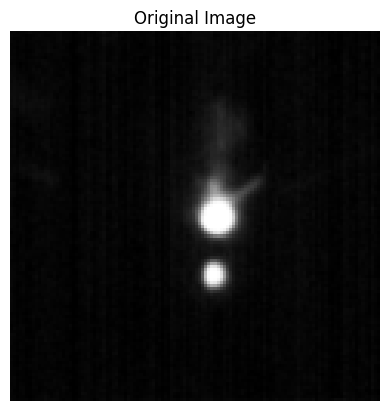

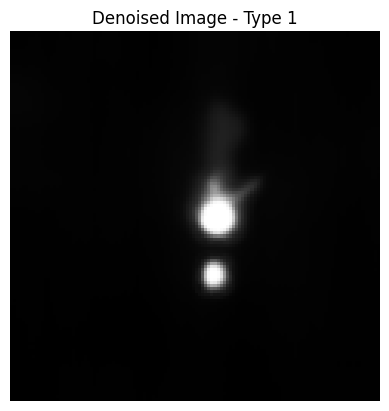

In [5]:
# Load the image
file_path = fLoc + '/Frame000156.bmp'
image = Image.open(file_path)

denoised_image_cv_pil = denoise_type1(image)

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Display the denoised image
plt.imshow(denoised_image_cv_pil, cmap='gray')
plt.title('Denoised Image - Type 1')
plt.axis('off')
plt.show()

## [Type 2] Exclude plume
* Type 2 - Exclude plume
* exclude_type2(image) Function
 - Threshold = 75 gray level

In [6]:
def exclude_type2(image):

  # Convert the original image to grayscale using OpenCV (for consistency with OpenCV processing)
  # gray_image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
  gray_image_cv = np.array(image) # image already changed into Gray sc

  # Define the gray level threshold
  threshold = 75

  # Identify pixels above the threshold
  above_threshold = gray_image_cv > 75

  # Create a mask where pixels above the threshold are kept, and others are set to threshold #0 (Setting to black makes image looks not real)
  masked_image_np = np.where(above_threshold, gray_image_cv, threshold)

  # Convert the masked array back to an image
  masked_image = Image.fromarray(masked_image_np.astype('uint8'))

  return masked_image

* Example - exclude_type2 function
 - Exclude plume (Threshold = 75)



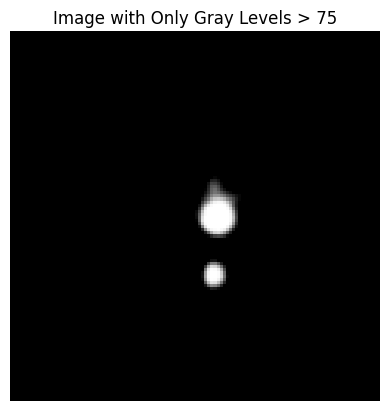

In [7]:
masked_image= exclude_type2(denoised_image_cv_pil)

# Display the masked image
plt.imshow(masked_image, cmap='gray')
plt.title('Image with Only Gray Levels > 75')
plt.axis('off')
plt.show()

## [Type 3] Exclude spatter
* Type 3 - Exclude spatter = only meltpool image
* exclude_type3(image) Function
 - Step 1: Find all contours
 - Step 2: Find largest contour (we assume that it will be the contour of meltpool)
 - Step 3: Masking largest contour

* Step 1 - find_contour(image) function

In [8]:
def find_contour(image):
  # Convert the image to a binary image for contour detection
  image = np.array(image) # if it works good keep it
  # threshold parameter(2nd) - 75 gray level(wide - more natural) / 150G (narrow)
  ret, binary_thresh = cv2.threshold(image, 75, 255, cv2.THRESH_BINARY)

  # Find contours in the binary thresholded image
  contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Check if contours are found to proceed
  if contours:
      # Create an empty image for drawing contours
      # contour_image = np.zeros_like(denoised_image_cv)

      # Draw contours on the original(denoised) image
      contour_image = image.copy()

      # Draw the contours
      # -1 signifies drawing all contours
      cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1) # Changing color is not working -- Need to check

      # Calculate the area of each contour
      contour_areas = [cv2.contourArea(contour) for contour in contours]

      # Convert contour image to PIL image for display
      contour_image_pil = Image.fromarray(contour_image)

      return contour_image_pil

  else:
      return "No contours found."


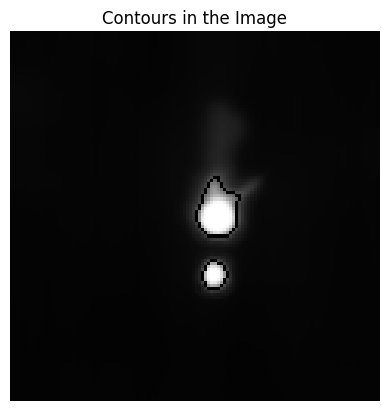

In [9]:
contour_image_pil = find_contour(denoised_image_cv_pil)

# Display the image with contours and return the areas
plt.imshow(contour_image_pil, cmap='gray')
plt.title('Contours in the Image')
plt.axis('off')
plt.show()

* Step 2: Find largest contour
 - largest_contour(image) function

In [10]:
def largest_contour(image):
  # Convert the image to a binary image for contour detection
  image = np.array(image) # if it works good keep it
  # threshold parameter(2nd) - 75 gray level(wide - more natural) / 150G (narrow)
  ret, binary_thresh = cv2.threshold(image, 75, 255, cv2.THRESH_BINARY)

  # Find contours in the binary thresholded image
  contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Find the largest contour
  largest_contour = max(contours, key=cv2.contourArea)

  # Draw contours on the original(denoised) image
  contour_image = image.copy()
  largest_image = cv2.drawContours(contour_image, [largest_contour], -1, (0, 255, 0), 1)

  # Convert the denoised image to PIL image for display
  eliminated_image_cv_pil = Image.fromarray(largest_image)

  return eliminated_image_cv_pil

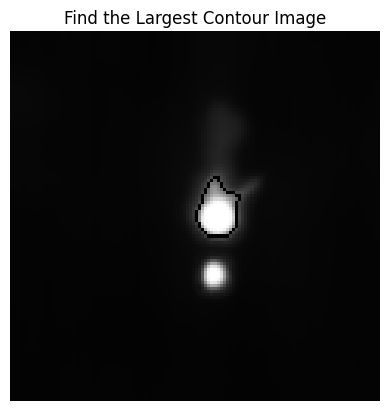

In [11]:
eliminated_image_cv_pil = largest_contour(denoised_image_cv_pil)

# Display the original image
plt.imshow(eliminated_image_cv_pil, cmap='gray')
plt.title('Find the Largest Contour Image')
plt.axis('off')
plt.show()

* Step 3: Only Melt-pool image
 - Masking largest contour

In [13]:
def only_meltpool(image):
    # Convert the image to a binary image for contour detection
    image = np.array(image)   # if it works good keep it
    # threshold parameter(2nd) - 75 gray level(wide - more natural) / 150G (narrow)
    ret, binary_thresh = cv2.threshold(image, 75, 255, cv2.THRESH_BINARY)

    # Find contours in the binary thresholded image
    contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if any contours were found
    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Create an empty mask for drawing the largest contour
        mask = np.zeros_like(image)

        # Draw the largest contour on the mask
        cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)

        # Create an image with only the largest contour area
        largest_contour_image = cv2.bitwise_and(image, image, mask=mask)

        # Fill the black area with threshold value
        largest_contour_image[largest_contour_image == 0] = 75
    else:
        # Handle the case with no contours
        # Returning the a blank image
        largest_contour_image = np.zeros_like(image)
        # or return original image use 'image'
        #largest_contour_image = image

    # Convert the image to PIL format
    largest_image_cv_pil = Image.fromarray(largest_contour_image)

    return largest_image_cv_pil

Text(0.5, 1.0, 'Only Melt-pool Image')

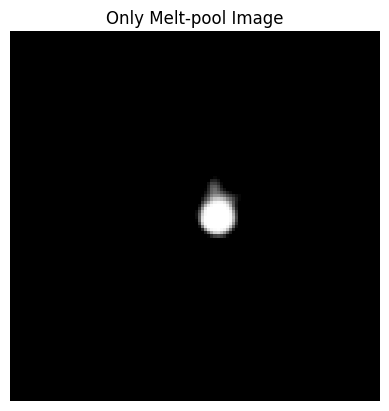

In [14]:
meltpool_image_ex = only_meltpool(denoised_image_cv_pil)

# Display the original image
plt.imshow(meltpool_image_ex, cmap='gray')
plt.axis('Off')
plt.title('Only Melt-pool Image')


## Calculate the melt-pool area
* Threshold = 150

In [15]:
def cal_melt_area(image):
  # Define the gray level meltpool threshold
  mp_threshold = 150

  # Convert the image into np array
  # Convert the image to a binary image for contour detection
  image = np.array(image) # if it works good keep it

  # Identify pixels above the threshold
  above_threshold = image > mp_threshold

  # Calculate the area (number of pixels above the threshold)
  area = np.sum(above_threshold)

  #Area (number of pixels)
  return area

## Main Part
  * Read the XYPT, DAQ data and merge them into a table
  * Convert original images to only meltpool image
  * Create a new CSV file and save the meltpool area value with the filename as an index
  * Linear Regression - 'Monitored Power' and 'Area'

In [16]:
# MAIN PART
# Check and sort the meltpool images in imageList
fLoc = './MPM_Part04_L0001'
imageList = os.listdir(fLoc)
imageList.sort()
imageList


# Create XYPT data frame
colnames_XYPT = ['X','Y','Designed Power','Trigger']

XYPT_df = pd.read_csv('XYPT_Part04_L0001.csv',names=colnames_XYPT)
XYPT_df = XYPT_df.reset_index()

# Create DAQ data frame
colnames_DAQ = ['DAQ_X','DAQ_Y','DAQ_LTZ','Monitored Power']
DAQ_df = pd.read_csv('DAQ_Part04_0001.csv', names=colnames_DAQ)
DAQ_df = DAQ_df.reset_index()

# Merge XYPT and DAQ data into one dataframe
comb_df = pd.merge(XYPT_df, DAQ_df, on = 'index')
#comb_df

# Meltpool monitoring image is captured when Trigger is '2'
mpm_df = comb_df[ comb_df['Trigger'] == 2 ]
#mpm_df

# change index with file names
# matching images with data
mpm_df.index = imageList[:]
mpm_df = mpm_df.iloc[:,1:]
mpm_df


,X,Y,Designed Power,Trigger,DAQ_X,DAQ_Y,DAQ_LTZ,Monitored Power
Frame000002.bmp,6.00,-11.00,100,2,5.920898,-10.944670,0.517159,-0.070526
Frame000003.bmp,6.09,-11.00,100,2,5.988801,-10.937079,0.519316,95.384870
Frame000004.bmp,6.18,-11.00,100,2,6.075803,-10.944670,0.522048,93.938225
Frame000005.bmp,6.27,-11.00,100,2,6.164926,-10.938344,0.524157,95.225970
Frame000006.bmp,6.36,-11.00,100,2,6.250867,-10.940874,0.526266,94.246092
...,...,...,...,...,...,...,...,...
Frame005918.bmp,6.10,-15.64,195,2,5.983496,-15.535642,0.729048,185.983908
Frame005919.bmp,6.10,-15.72,195,2,5.986679,-15.629258,0.732403,186.847922
Frame005920.bmp,6.10,-15.80,195,2,6.014265,-15.724139,0.734512,187.804628
Frame005921.bmp,6.10,-15.88,195,2,5.999411,-15.778537,0.738634,185.414519


In [17]:
# From the image
# 1) Obtain processed images
# 2) Calculate the meltpool area

for filename in imageList[:1000]:
#for filename in imageList:
  # Load the image
  file_path = fLoc + '/' + filename
  image = Image.open(file_path)

  # Task - Erase Type 1
  denoised_image_cv_pil = denoise_type1(image)
  #image2=denoised_image_cv_pil
  #image3=denoised_image_cv_pil
  type1_folder = './type1_Images'

  # Create the output directory if it doesn't exist
  if not os.path.exists(type1_folder):
      os.makedirs(type1_folder)

  # Save the processed image to the output folder
  output1_path = os.path.join(type1_folder, 'type1_'+filename)
  denoised_image_cv_pil.save(output1_path, format='BMP')

  # Task - Erase Type2
  masked_image= exclude_type2(denoised_image_cv_pil)

  type2_folder = './type2_Images'

  # Create the output directory if it doesn't exist
  if not os.path.exists(type2_folder):
      os.makedirs(type2_folder)

  # Save the processed image to the output folder
  output2_path = os.path.join(type2_folder, 'type2_'+filename)
  masked_image.save(output2_path, format='BMP')




In [18]:
# Task 3 - Obtain only meltpool images

for filename in imageList[:1000]:
#for filename in imageList:
  # Load the image
  file_path = fLoc + '/' + filename
  image = Image.open(file_path)

  # Task - Erase Type 3
  # Obtain only meltpool image - Erase Type1, Type 2, Type 3
  denoised_image_cv_pil2 = denoise_type1(image)

  meltpool_image = only_meltpool(denoised_image_cv_pil2)
  type3_folder = './only_meltpool_Images'

  # Create the output directory if it doesn't exist
  if not os.path.exists(type3_folder):
      os.makedirs(type3_folder)

  # Save the processed image to the output folder
  output3_path = os.path.join(type3_folder, 'Meltpool_'+filename)
  meltpool_image.save(output3_path, format='BMP')

  # Calculate meltpool area
  area = cal_melt_area(meltpool_image)
  # Update the Area in the DataFrame for the corresponding filename
  mpm_df.at[filename, 'Area'] = area
  #if filename in mpm_df.index:
  #    mpm_df.at[filename, 'Area'] = area

In [19]:
# Skip the case when the monitored power and designed power
# No interaction --> No melt-pool
mpm_df.loc[mpm_df['Monitored Power'] < (0.9 * mpm_df['Designed Power']), 'Area'] = float('NaN')
mpm_df

,X,Y,Designed Power,Trigger,DAQ_X,DAQ_Y,DAQ_LTZ,Monitored Power,Area
Frame000002.bmp,6.00,-11.00,100,2,5.920898,-10.944670,0.517159,-0.070526,NaN
Frame000003.bmp,6.09,-11.00,100,2,5.988801,-10.937079,0.519316,95.384870,86.0
Frame000004.bmp,6.18,-11.00,100,2,6.075803,-10.944670,0.522048,93.938225,132.0
Frame000005.bmp,6.27,-11.00,100,2,6.164926,-10.938344,0.524157,95.225970,172.0
Frame000006.bmp,6.36,-11.00,100,2,6.250867,-10.940874,0.526266,94.246092,124.0
...,...,...,...,...,...,...,...,...,...
Frame005918.bmp,6.10,-15.64,195,2,5.983496,-15.535642,0.729048,185.983908,NaN
Frame005919.bmp,6.10,-15.72,195,2,5.986679,-15.629258,0.732403,186.847922,NaN
Frame005920.bmp,6.10,-15.80,195,2,6.014265,-15.724139,0.734512,187.804628,NaN
Frame005921.bmp,6.10,-15.88,195,2,5.999411,-15.778537,0.738634,185.414519,NaN


## Perform Linear Regression

Coefficients: [2.06930502]
Intercept: -56.42448151425339
Mean squared error (MSE): 2099.1398817783834
Coefficient of determination (R^2): 0.7626536892502357
Mean absolute error (MAE): 32.611552720451385


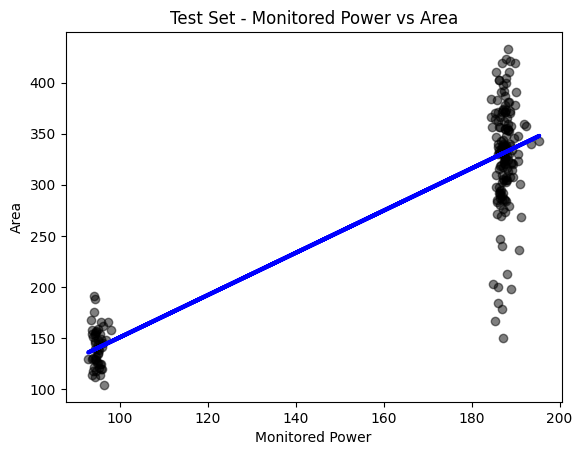

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Take the Monitored Power and Area from dataframe
# And does not consider 'NaN' cases of 'Area'
mpm_df_cleaned = mpm_df.dropna(subset=['Monitored Power', 'Area'])

# Prepare the data
X = mpm_df_cleaned[['Monitored Power']]
y = mpm_df_cleaned['Area']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # 80% training, 20% testing

# Create linear regression object
regressor = LinearRegression()

# Train the model using the training sets
regressor.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regressor.predict(X_test)

# Evaluate the model
print('Coefficients:', regressor.coef_)
print('Intercept:', regressor.intercept_)
print('Mean squared error (MSE):', mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2):', r2_score(y_test, y_pred))
print('Mean absolute error (MAE):', mean_absolute_error(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test, color='black', alpha=0.5)
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Monitored Power')
plt.ylabel('Area')
plt.title('Test Set - Monitored Power vs Area')
plt.show()